# PHYS142 Final Project: 2D Ising Model with MCMC Group B
Group members: Matthew Yao, Ashleann Chen, Sophie Carlson

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.sparse.linalg
import tqdm
import numba as nb
%matplotlib widget

## Metropolis-Hastings algorithm with Numba

In [2]:
# numba implementation of Metropolis-Hastings algorithm
# 300x faster than reference implementation
@nb.njit
def ising_mcmc_numba(lattice_spins, STEPS, rand, rand_pos, T, B):
    # INPUTS: 
    #   lattice_spins: 2d np array of initial spins
    #   STEPS: number of steps
    #   rand: list of random numbers [0, 1] of length STEPS 
    #   rand_pos: list of random positions (i, j) of length STEPS
    #   T: temperature as a np array of length STEPS
    #   B: external magnetic field as a np array of length STEPS

    # Outputs: 
    # Tuple (num_accept, m_values)
    #     num_accept: number of spin flips
    #     m_values: np array of m values 

    m_values = np.zeros(STEPS)
    sum_spins = np.sum(lattice_spins)
    num_accept = 0
    for t in range(STEPS):
        i, j = rand_pos[t]
        # Calculate Delta energy
        delta_energy = 2 * B[t] * lattice_spins[i, j]
        
        i_neigh = i + -1 if i + -1 < N else 0
        j_neigh = j + 0 if j + 0 < N else 0
        delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
        i_neigh = i + 1 if i + 1 < N else 0
        j_neigh = j + 0 if j + 0 < N else 0
        delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
        i_neigh = i + 0 if i + 0 < N else 0
        j_neigh = j + 1 if j + 1 < N else 0
        delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]
        i_neigh = i + 0 if i + 0 < N else 0
        j_neigh = j + -1 if j + -1 < N else 0
        delta_energy += -J * -2 * lattice_spins[i, j] * lattice_spins[i_neigh, j_neigh]

        #Decide whether to flip the spin
        if delta_energy <= 0:
            lattice_spins[i, j] *= -1
            sum_spins += 2*lattice_spins[i, j]
            num_accept += 1
        elif delta_energy > 0:
            prob = np.exp(-delta_energy / (KB * T[t]))
            if rand[t] < prob:
                lattice_spins[i, j] *= -1
                sum_spins += 2*lattice_spins[i, j]
                num_accept += 1
        m_values[t] = sum_spins / N**2
    return (num_accept, m_values)

# Wrapper for above which generates random data
def ising_mcmc(lattice_spins, STEPS, T, B):
    # INPUTS: 
    #   lattice_spins: 2d np array of initial spins
    #   STEPS: number of steps
    #   T: temperature as a number or np array
    #   B: external magnetic field as a number or np array
    # Outputs: 
    # Tuple (num_accept, m_values)
    #     num_accept: number of spin flips
    #     m_values: np array of m values 
    rand = np.random.rand(STEPS)
    rand_pos = np.random.randint(0, N, size=(STEPS, 2))
    T_list = T
    B_list = B

    if not isinstance(T, np.ndarray):
        T_list = np.full(STEPS, T)
    if not isinstance(B, np.ndarray):
        B_list = np.full(STEPS, B)
    
        
    return ising_mcmc_numba(lattice_spins, STEPS, rand, rand_pos, T_list, B_list)

In [3]:
def random_lattice(N, B, T):
    lattice_spins = np.ones((N, N))
    rand = np.random.rand(N, N)
    p_down = np.exp(-B/T) / (2 * np.cosh(B / T))
    lattice_spins[np.where(rand < p_down)] = -1
    return lattice_spins

def random_lattice_prob(N, p, T): # p = prob of spin up
    lattice_spins = np.ones((N, N))
    rand = np.random.rand(N, N)
    lattice_spins[np.where(rand > p)] = -1
    return lattice_spins

In [4]:
STEPS = 1_000_000
N = 100
J = 1
KB = 1
T = 2
B = 1

# initialize random lattice
lattice_spins_rand = 2 * (np.random.randint(2, size=(N, N)) - 0.5)
# initialize ordered lattice with all spins up
lattice_spins = np.ones((N, N))
m_values = np.zeros(STEPS)
num_accept, m_values = ising_mcmc(lattice_spins_rand, STEPS, T, B)

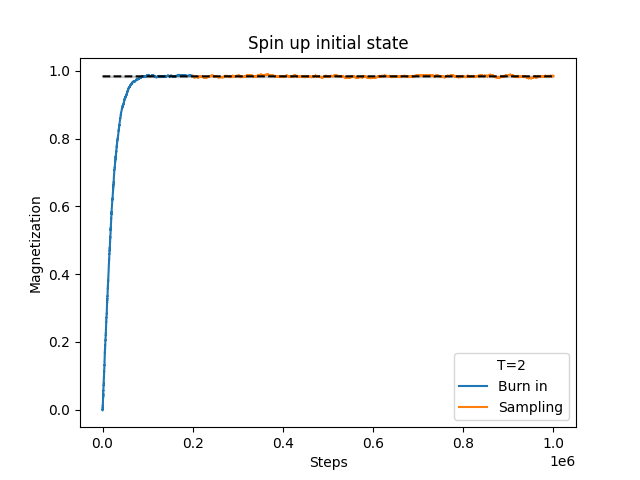

magnetization mean = 0.9840568522500001
magnetization std = 0.002016109737010846


In [5]:
BURNIN = 200_000

m_mean = np.mean(m_values[BURNIN:])
m_std = np.std(m_values[BURNIN:])

plt.figure()
plt.plot(range(STEPS)[:BURNIN], m_values[:BURNIN], label="Burn in")
plt.plot(range(STEPS)[BURNIN:], m_values[BURNIN:], label="Sampling")
# show mean as dashed line
plt.plot(range(STEPS), m_mean * np.ones((STEPS)), "--", color="black")
# show variance as filled box
plt.fill_between(range(STEPS), m_mean - m_std, m_mean + m_std, color="gray", alpha=0.3)
plt.xlabel("Steps")
plt.ylabel("Magnetization")
plt.title("Spin up initial state")
plt.legend(title=f"T={T}")
#plt.savefig('figures/spinup.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

print(f"magnetization mean = {m_mean}")
print(f"magnetization std = {m_std}")

## M vs T for fixed B

In [14]:
T_list = np.arange(.5, 20, .1)
B_list = np.array([-1, 0, 1])

m_mean_matrix = np.zeros((len(B_list), len(T_list)))
m_std_matrix = np.zeros((len(B_list), len(T_list)))
for i in tqdm.tqdm(range(len(B_list))):
    for j in range(len(T_list)):
        BURNIN = 200_000
        STEPS = 1_000_000
        B = B_list[i]
        T = T_list[j]

        if(B == 0):
            lattice_spins = random_lattice(N, .5, T)
        else:
            lattice_spins = random_lattice(N, B, T)
        
        num_accept, m_values = ising_mcmc(lattice_spins, STEPS, T, B)
        m_mean_matrix[i, j] = np.mean(m_values[BURNIN:])
        m_std_matrix[i, j] = np.std(m_values[BURNIN:])

100%|███████████████████████████████████████████████████| 3/3 [00:28<00:00,  9.60s/it]


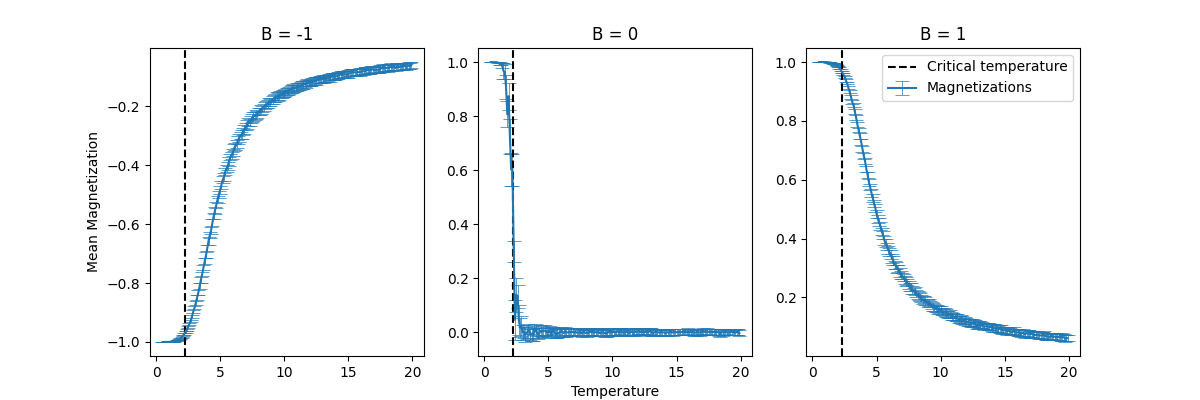

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i].errorbar(T_list, m_mean_matrix[i, :], yerr=m_std_matrix[i, :], capsize=5, capthick=.5, elinewidth=.5, label="Magnetizations")
    axes[i].set(title=f'B = {B_list[i]}')
    axes[i].axvline(x=2.269, color='black', linestyle='--', label='Critical temperature') 

axes[1].set(xlabel='Temperature')
axes[0].set(ylabel='Mean Magnetization')

plt.legend()
#plt.savefig('figures/crit.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.savefig('figures/m_vs_t.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## M vs B for fixed T

In [9]:
T_list = [1.5, 2.269, 5]
B_list = np.arange(-1, 1, .05)

m_mean_matrix = np.zeros((len(B_list), len(T_list)))
m_std_matrix = np.zeros((len(B_list), len(T_list)))
for i in tqdm.tqdm(range(len(B_list))):
    for j in range(len(T_list)):
        BURNIN = 200_000
        STEPS = 1_000_000
        B = B_list[i]
        T = T_list[j]

        
        # initialize random lattice
        lattice_spins = random_lattice(N, B, T)
        
        num_accept, m_values = ising_mcmc(lattice_spins, STEPS, T, B)
        m_mean_matrix[i, j] = np.mean(m_values[BURNIN:])
        m_std_matrix[i, j] = np.std(m_values[BURNIN:])

100%|█████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.72it/s]


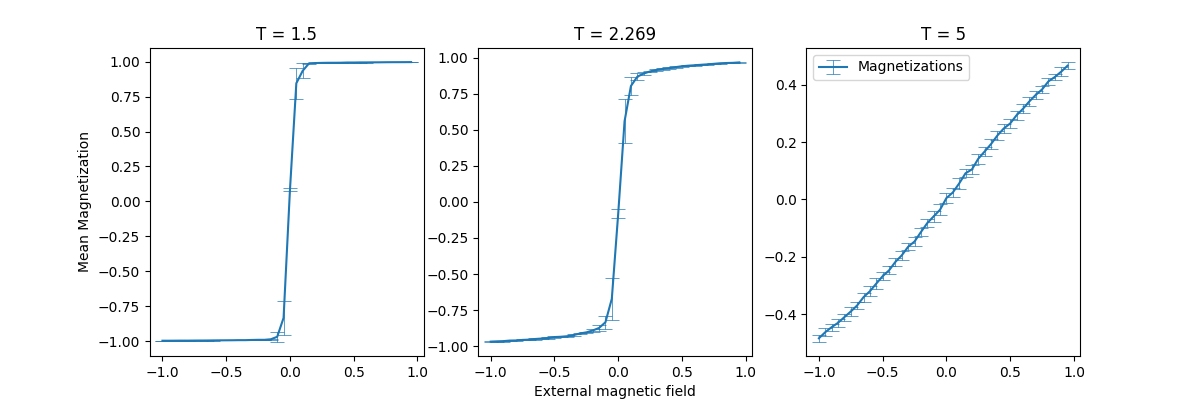

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i].errorbar(B_list, m_mean_matrix[:, i], yerr=m_std_matrix[:, i], capsize=5, capthick=.5, elinewidth=.5, label="Magnetizations")
    axes[i].set(title=f'T = {T_list[i]}')
axes[1].set(xlabel='External magnetic field')
axes[0].set(ylabel='Mean Magnetization')

plt.legend()
plt.savefig('figures/m_vs_B.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## M vs B and T

In [12]:
T_list = np.arange(.5, 10, .2)
B_list = np.arange(-1, 1, .05)

m_mean_matrix = np.zeros((len(B_list), len(T_list)))
for i in tqdm.tqdm(range(len(B_list))):
    for j in range(len(T_list)):
        BURNIN = 200_000
        STEPS = 1_000_000
        B = B_list[i]
        T = T_list[j]

        lattice_spins = random_lattice(N, B, T)
        #lattice_spins = np.ones((N, N))
        num_accept, m_values = ising_mcmc(lattice_spins, STEPS, T, B)
        m_mean = np.mean(m_values[BURNIN:])
        m_mean_matrix[i, j] = m_mean
        

100%|█████████████████████████████████████████████████| 40/40 [01:31<00:00,  2.30s/it]


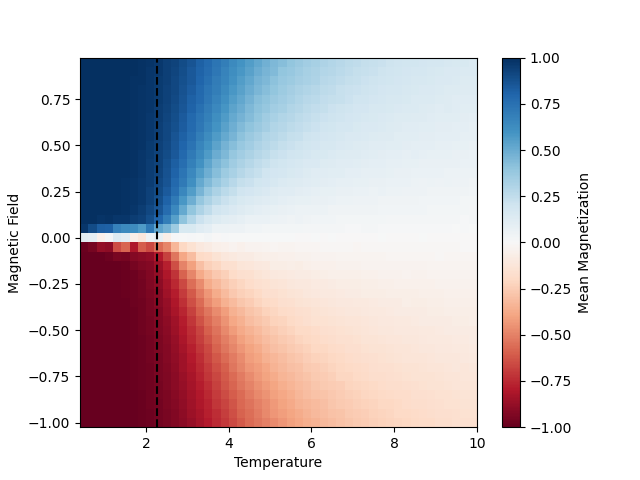

In [13]:
fig, ax = plt.subplots()
plt.pcolormesh(T_list, B_list, m_mean_matrix, shading='auto', cmap='RdBu')
plt.axvline(x=2.269, color='black', linestyle='--', label='Critical temperature') 
plt.xlabel('Temperature')
plt.ylabel('Magnetic Field')
plt.colorbar(label = 'Mean Magnetization')
plt.savefig('figures/phase.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Hysteresis 

In [16]:
B = np.concatenate((np.linspace(0, 1, 1_000_000), np.linspace(1, -1, 2_000_000), np.linspace(-1, 1, 2_000_000)))
STEPS = B.size
N = 100
J = 1
KB = 1
T = 2

# initialize random lattice
lattice_spins_rand = 2 * (np.random.randint(2, size=(N, N)) - 0.5)
# initialize ordered lattice with all spins up
num_accept, m_values = ising_mcmc(lattice_spins_rand, STEPS, T, B)

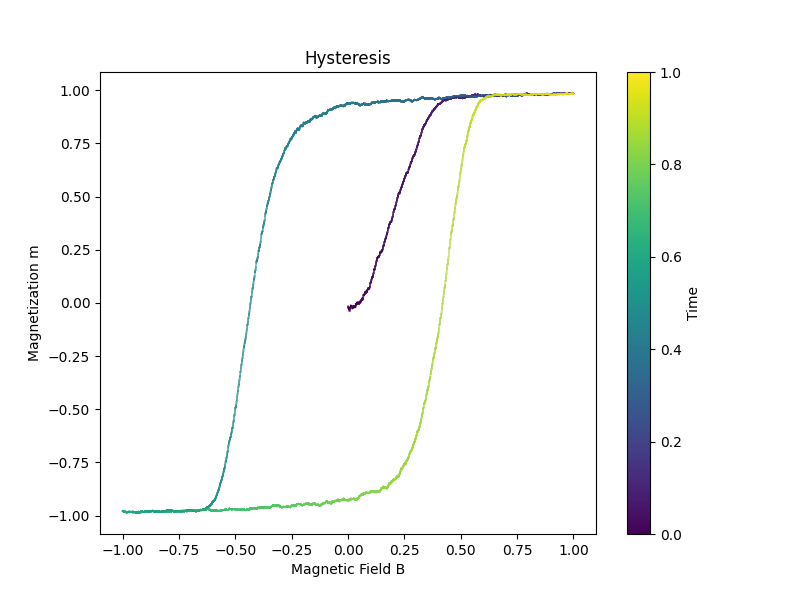

In [17]:
from matplotlib.colors import LinearSegmentedColormap
BURNIN = 0
fig = plt.figure(figsize=(8, 6))
n = 50
colors = np.linspace(0, 1, STEPS//n)
cmap = plt.get_cmap("viridis") 
plt.scatter(B[::n], m_values[::n], s = .001, c=colors, cmap=cmap)
plt.colorbar(label='Time')
plt.xlabel('Magnetic Field B')
plt.ylabel('Magnetization m')
plt.title('Hysteresis')
plt.savefig('figures/hysteresis.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Magnetization vs Temperature for B = 0

In [15]:
T_list = np.arange(.5, 10, .2)
p_list = np.arange(-1, 1, .05)

m_mean_matrix = np.zeros((len(p_list), len(T_list)))
for i in tqdm.tqdm(range(len(p_list))):
    for j in range(len(T_list)):
        BURNIN = 200_000
        STEPS = 1_000_000
        p = p_list[i]
        T = T_list[j]

        lattice_spins = random_lattice_prob(N, p, T)
        num_accept, m_values = ising_mcmc(lattice_spins, STEPS, T, 0)
        m_mean = np.mean(m_values[BURNIN:])
        m_mean_matrix[i, j] = m_mean
    

100%|█████████████████████████████████████████████████| 40/40 [01:29<00:00,  2.24s/it]


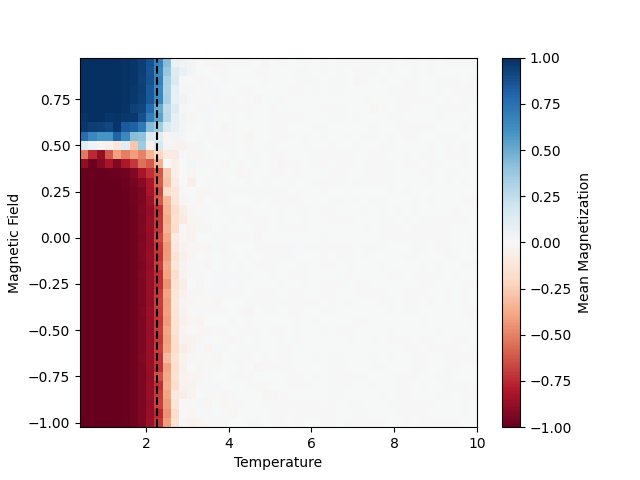

In [16]:
fig, ax = plt.subplots()
plt.pcolormesh(T_list, B_list, m_mean_matrix, shading='auto', cmap='RdBu')
plt.axvline(x=2.269, color='black', linestyle='--', label='Critical temperature') 
plt.xlabel('Temperature')
plt.ylabel('Magnetic Field')
plt.colorbar(label = 'Mean Magnetization')
plt.show()